**Use of this document:**
This is a template for generating nestling age models from common morphological measurements using R.  The models that were developed in the manuscript are specific to the Western Bluebird, but the process could easily be adapted for other bird species.

The following code chunks demonstrate the process used to build a model from morphological measurements.

**Packages needed for analysis**

In [24]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(readr)
library(caret)
library(lmerTest)
library(lme4)

**Step 1: Import Data**
Use read_csv() or a similar function to import data.

In [25]:
options(warn=-1)
mass_df <- read_csv('Data/dummy_data.csv')

# Make Year and ID factors
mass_df$Year <- as.factor(data$Year)
mass_df$ID <- as.factor(data$ID)

Parsed with column specification:
cols(
  Year = col_double(),
  Day = col_double(),
  ID = col_character(),
  Mass = col_double()
)



**Step 2: Format Data**
Your data should have a format similar to this. Note the data types listed below each column name.

Because the measured variable Tarsus, Culmen, and Mass are all highly correlated, we created separate models for each. To make the modeling simpler, we split the data into individual dataframes for each variable. The sample dataset provided just includes randomly generated mass measurements for demonstration purposes.

In [26]:
head(mass_df)

Year,Day,ID,Mass
<fct>,<dbl>,<fct>,<dbl>
2015,1,bird1,1.369661
2015,2,bird1,2.079658
2015,3,bird1,3.561813
2015,4,bird1,8.827571
2015,5,bird1,8.952787
2015,6,bird1,9.421199


**Step 3: Examine Data**
Estimate the age range that can be used in the model. This can be done by plotting all the data for each measurement and visually assessing if there is a day when the relationship starts to break down. 

For example:

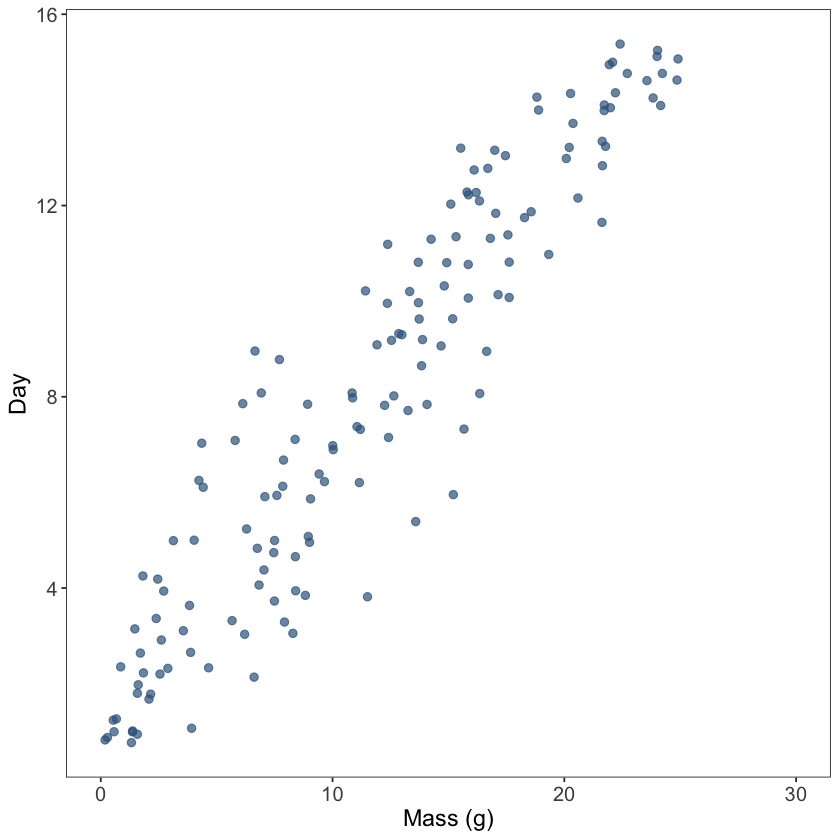

In [27]:
ggplot(mass_df, aes(Mass, Day)) +
    geom_jitter(data = data, aes(Mass, Day), alpha = 0.7, size = 2, color = 'steelblue4') +
    theme_bw() +
    xlab('Mass (g)') + 
    xlim(0, 30) + 
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          legend.position = c(0.7, 0.2),
          axis.text = element_text(size = 12),
          axis.title = element_text(size = 14),
          legend.text = element_text(size = 12))

**Step 4: Build the Models**
Once the appropriate age range has been determined, start building models based on that subset of data.

1. First split the data into a training and test set. Based on the amount of data we had, we chose a 90:10 training:test split.  This split may change based on your data. We used the createDataPartition function in R's caret package to create the split.

In [28]:
set.seed(18) # This could be any number - just ensures that the split is reproducible

split <- createDataPartition(mass_df$Mass, p = 0.9, list = FALSE)  

train <- mass_df[split,] # The training set is 90% of the data
test <- mass_df[-split,] # The test set is the remaining 10%

2. Fit a mixed model on the training data. Start with a linear model. If the fit is poor, increase to a quadratic or cubic using the poly() function.

In [29]:
model_mass <- lmer(Day ~ Mass + (1|ID), data = train) 
summary(model_mass)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Day ~ Mass + (1 | ID)
   Data: train

REML criterion at convergence: 427.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.57362 -0.59849 -0.03334  0.58850  2.44273 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 1.371    1.171   
 Residual             1.007    1.004   
Number of obs: 138, groups:  ID, 10

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.85122    0.40825  11.90267   2.085   0.0593 .  
Mass          0.61619    0.01276 128.01991  48.291   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
Mass -0.365

3. Make predictions based on the model.

In [30]:
p_mass <- predict(model_mass, test, allow.new.levels = TRUE) 
actual <- test$Day

error <- p_mass - actual

test$predicted <- p_mass

4. Calculate root-mean squared error (RMSE). Compare RMSE generated from linear, quadratic, and cubic models to select the best model. If RMSE is similar between two models, choose the one with fewer terms.

In [31]:
RMSE <- sqrt(mean((error)^2, na.rm = T))
RMSE

[1] 1.366843

5. Plot the data to check the model.

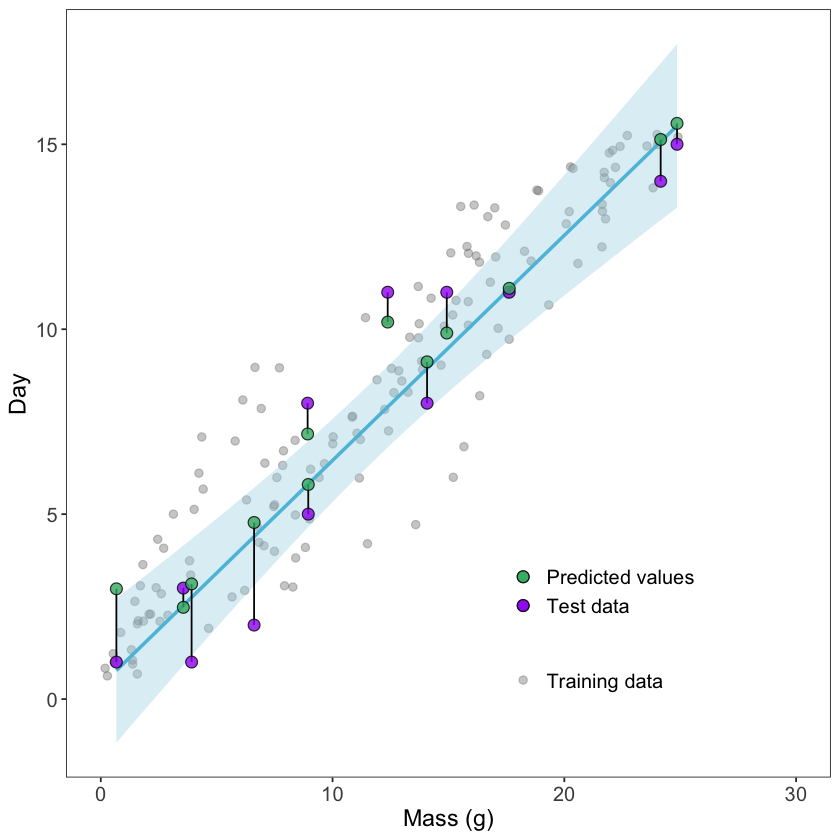

In [34]:
ggplot(test, aes(Mass, Day)) +
  geom_jitter(data = train, aes(Mass, Day, color = 'Training data'), alpha = 0.4, size = 2) + 
  # this needs to be changed depending on what order equation is chosen
  geom_smooth(method = 'lm', se = TRUE, color = '#5bc0de', level = 0.95, fill = 'lightblue') + 
  geom_segment(aes(x = Mass, y = Day, xend = test$Mass, yend = predicted), color = 'black') + 
  geom_point(aes(fill = 'Test data'), pch = 21, color = 'black', alpha = 0.8, size = 3) +
  geom_point(data = test, aes(y = p_mass, fill = 'Predicted values'), pch = 21, size = 3, color = 'black', alpha = 0.8) +
  scale_fill_manual(name = NULL, values = c('mediumseagreen', 'purple')) +
  scale_color_manual(name = NULL, values = c('grey50')) +
  theme_bw() +
  xlab('Mass (g)') + 
  xlim(0, 30) + 
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = c(0.7, 0.2),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12))